In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import datetime

import scipy.optimize as spo
import scipy.integrate as spi

## Data Preprocessing

The dataset we will be using is the Global Coronavirus (COVID-19) Data (Corona Data Scraper) provided by Enigma. 

[AWS product link](https://aws.amazon.com/marketplace/pp/prodview-vtnf3vvvheqzw?qid=1597409751562&sr=0-1&ref_=brs_res_product_title#overview)
[Corona Data Scraper page](https://coronadatascraper.com/#home)


We are only interested in the state-level data in United States. To save time from opening a super large dataset, we save each state's data into small files.

In [2]:
df = pd.read_csv("datasets/timeseries.csv")
df_US = df[(df["country"]=="United States") & (df["level"]=="state")]
df_US = df_US[["state", "population", "cases", "deaths", "recovered", "tested", "hospitalized", "date"]]

/Users/xinyi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
states = np.unique(df_US["state"])
for state in states:
    df_US[df_US["state"]==state].to_csv("datasets/timeseries_states/"+state+".csv", index=0)

## State Data Snapshot

In [4]:
def chooseState(state):
    df_state = pd.read_csv("datasets/timeseries_states/"+state+".csv")
    
    ### data cleaning
    
    # some col is missing in some state's report
    na_cols = []
    for col in df_state.columns.values:
        if df_state[col].isna().all():
            na_cols.append(col)
    if na_cols == []:
        print("Data complete, ready to analyze.")
    else:
        print("Data incomplete, cannot analyze.")
        print("NA cols: ", na_cols)
    for col in na_cols:
        df_state = df_state.drop(col, axis=1)

    # some data is missing at the beginning of the outbreak
    ncols = len(df_state.columns.values)
    for i in range(len(df_state.index)):
        if df_state.iloc[i].notna().all():
            print("Suggest choosing start date after", df_state.iloc[i]["date"])
            break
    df_state.fillna(0)
    
    ### snapshot and mark data inconsistency
    plt.figure()
    plt.title(state)
    
    if "cases" in df_state.columns.values:
        plt.plot(df_state["cases"], "-b", label="cases")
        for i in range(1, len(df_state.index)):
            if abs(df_state["cases"][i] - df_state["cases"][i-1]) > 50000:
                plt.plot(i, df_state["cases"][i], "xr")
    if "deaths" in df_state.columns.values:
        plt.plot(df_state["deaths"], "-k", label="deaths")
        for i in range(1, len(df_state.index)):
            if abs(df_state["deaths"][i] - df_state["deaths"][i-1]) > 50000:
                plt.plot(i, df_state["deaths"][i], "xr")
    if "recovered" in df_state.columns.values:
        plt.plot(df_state["recovered"], "-g", label="recovered")
        for i in range(1, len(df_state.index)):
            if abs(df_state["recovered"][i] - df_state["recovered"][i-1]) > 50000:
                plt.plot(i, df_state["recovered"][i], "xr")
            
    plt.legend()
    
    #### change data type for date
    df_state["date"] = pd.to_datetime(df_state["date"])
    
    return df_state

For example, we are interested in New York state.

Data complete, ready to analyze.
Suggest choosing start date after 2020-03-27


,state,population,cases,deaths,recovered,tested,hospitalized,date
54,New York,19453561,2382.0,12.0,NaN,14597.0,NaN,2020-03-18
64,New York,19453561,52318.0,728.0,2726.0,155934.0,10454.0,2020-03-28
86,New York,19453561,242786.0,13869.0,37596.0,617555.0,64550.0,2020-04-19
130,New York,19453561,373040.0,24023.0,66262.0,2167831.0,89861.0,2020-06-02
146,New York,19453561,385760.0,24661.0,69243.0,3179660.0,89995.0,2020-06-18


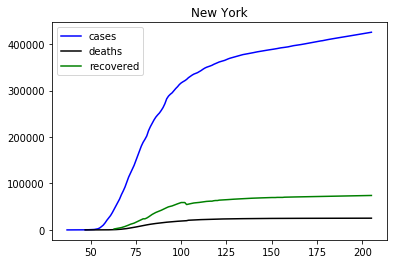

In [5]:
state = "New York"
df_state = chooseState(state)
df_state.sample(5).sort_values("date")

For example, we are interested in the first two weeks in April.

In [6]:
def chooseTime(df_state, start_date, end_date):
    start = np.datetime64(start_date)
    end = np.datetime64(end_date)
    
    # The time period of interest 
    sample = df_state[ (df_state["date"] >= start) & (df_state["date"] <= end) ]
    # The future period to determine "exposed"
    sample_future = df_state[ (df_state["date"] >= start + np.timedelta64(14,'D')) & (df_state["date"] <= end + np.timedelta64(14,'D')) ]

    return sample, sample_future

In [7]:
start_date, end_date = "2020-04-01", "2020-04-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)

## SEIR Infection Model

![title](model.png)

We can use an SEIR model to describe the transmission dynamics of Covid19 as above.

We Assume...

- Susceptible (S): healthy people, will be infected and turn into E after close contact with E or Q.
- Exposed (E): infected but have no symptoms yet, infectious with a rate of $\lambda_E$. E will turn into I after the virus incubation period, which is 14 days on average. So we assume $\sigma = 1/14$, dE/dt (t) = dI/dt (t+14).
- Infectious (I): infected and have symptoms. We will take the data of test_positive or cases_reported as the data of I. The severe cases will be hospitalized (H), the mild cases will be in self quarantine (Q). I may recover or dead after some time.
    - Self Quarantine (Q): have symptoms, may still have some contact with others, infectious with a different rate of $\lambda_Q$. We assume $Q = kI$, where $k = 1 - avg(\frac{\Delta hospitalized}{\Delta test\_pos}) $
    - Hospitalized (H): have symptoms, kept in hospitals, assume no contact with S. 
- Recovered (R): recovered and immune, may turn into S again (immunity lost or virus not cleared)
- Dead (X): dead unfortunately :(



Therefore, we have a set of differential equations to describe this process:

$\begin{aligned}
&\frac{dS}{dt}&
&=& - \lambda_E \frac{S}{N} E - \lambda_Q \frac{S}{N} Q + \alpha R ~~~
&=& - \lambda_E \frac{S}{N} E - \lambda_Q \frac{S}{N} kI + \alpha R
\\
&\frac{dE}{dt}&
&=&   \lambda_E \frac{S}{N} E + \lambda_Q \frac{S}{N} Q - \sigma E ~~~
&=&   \lambda_E \frac{S}{N} E + \lambda_Q \frac{S}{N} kI - \sigma E
\\
&\frac{dI}{dt}&
&=& \sigma E - \mu I - \omega I 
\\
&\frac{dX}{dt}&
&=& \omega I 
\\
&\frac{dR}{dt}&
&=& \mu I - \alpha R 
\end{aligned}$

$S + E + I + R + X = N,~ I = Q + H$


Apply to our datasets, we have:

$ R = recovered,~ X = deaths,~ I = test\_pos - deaths - recovered,\\
E(t) = I(t+14) - I(t),~ S = N - E - I - R - X,\\
k = 1 - avg(\frac{\Delta hospitalized}{\Delta test\_pos})
$

In [8]:
### run SEIR model on sample data

def SEIR():
    
    ### differential equations for spi.odeint, INP - initial point, t - time range
    # dS/dt = - lamda_E*S/N*E - lamda_Q*S/N*k*I + alpha*R
    # dE/dt = lamda_E*S/N*E + lamda_Q*S/N*k*I - sigma*E
    # dI/dt = sigma*E - miu*I - omega*I
    # dX/dt = omega*I
    # dR/dt = miu*I - alpha*R
    def diff_eqs(INP, t, lamda_E_p, lamda_Q_p, alpha_p, omega_p, miu_p):
        Y = np.zeros((5))
        V = INP
        Y[0] = - lamda_E_p*V[0]/N*V[1] - lamda_Q_p*V[0]/N*k*V[2] + alpha_p*V[4]
        Y[1] =   lamda_E_p*V[0]/N*V[1] + lamda_Q_p*V[0]/N*k*V[2] - sigma*V[1]
        Y[2] = sigma*V[1] - miu_p*V[2] - omega_p*V[2]
        Y[3] = omega_p*V[2]
        Y[4] = miu_p*V[2] - alpha_p*V[4]
        return Y

    ### cost function for optimization
    def MSE(params):
        INP = (S[0], E[0], I[0], X[0], R[0])
        t_range = np.arange(0, len(S), 1)
        RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))
        mse = 0
        for i in range(len(S)):
            mse += ( (RES[i,0] - S[i]) ) **2
            mse += ( (RES[i,1] - E[i]) ) **2
            mse += ( (RES[i,2] - I[i]) ) **2
            mse += ( (RES[i,3] - X[i]) ) **2
            mse += ( (RES[i,4] - R[i]) ) **2
        mse = mse / len(S)
        return mse
    
    
    ### get necessary data from dataset

    cases = np.array(list(sample["cases"])) # test_positive
    cases_future = np.array(list(sample_future["cases"])) # to calculate exposed
    hospitalized = np.array(list(sample["hospitalized"])) # to calculate k
    deaths = np.array(list(sample["deaths"])) # X
    recovered = np.array(list(sample["recovered"])) # R
    N = np.mean(df_state["population"])
    
    X = deaths
    R = recovered
    I = cases - deaths - recovered
    E = cases_future - cases
    S = N - E - I - X - R

    dS = S[1:] - S[:-1]
    dE = E[1:] - E[:-1]
    dI = I[1:] - I[:-1]
    dX = X[1:] - X[:-1]
    dR = R[1:] - R[:-1]
    S = S[:-1]
    E = E[:-1]
    I = I[:-1]
    X = X[:-1]
    R = R[:-1]
    
    
    ### guess params
    # By experience: k, sigma
    k = 1 - np.mean( (hospitalized[1:]-hospitalized[0:-1]) / (cases[1:]-cases[:-1]) ) # k = deltaH / deltaCases
    sigma = 1/14 # virus incubation period = 14 days
    # From optimization: lamda_E, lamda_Q, alpha, omega, miu
    alpha0 = 0.006
    omega0 = np.mean(dX / I) # dx/dt = omega*i
    lamda0 = np.mean(-(dS - alpha0*R) / (S/N) / (E+k*I)) # dS/dt = - lamda*S/N*(E+kI) + alpha*R
    miu0 = np.mean((dR + alpha0*R) / I) # dr/dt = miu*i - alpha*r
    
    ### Optimization to find best params
    params0 = (1.5*lamda0, 0.6*lamda0, alpha0, omega0, miu0) # lamda_E, lamda_Q, alpha, omega, miu
    ret = spo.minimize(MSE, params0, bounds=[(0,1), (0,1), (0,1), (0,1), (0,1)])
    params = ret.x
    params0 = [round(i,6) for i in params0]
    params = [round(i,6) for i in params]
    print("Optimization for lamda_E, lamda_Q, alpha, omega, miu")
    print("params0: ", params0)
    print("params: ", params)
    
    
    ### solve ode and plot
    INP = (S[0], E[0], I[0], X[0], R[0])
    t_range = np.arange(0, len(S)*5, 1)
    RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))

    fig, ax1 = plt.subplots()
    #ax1.plot(RES[:,0], '-b', label='susceptible')
    ax1.plot(RES[:,1], '-b', label='exposed')
    ax1.plot(RES[:,2], '-r', label='infected')
    ax1.plot(RES[:,3], '-k', label='dead')
    ax1.plot(RES[:,4], '-g', label = 'recovered' )

    #ax1.plot(S, "xb", label="S")
    ax1.plot(E, "xb", label="E")
    ax1.plot(I, "xr", label="I")
    ax1.plot(X, "xk", label="X")
    ax1.plot(R, "xg", label="R")

    ax1.grid()
    ax1.set_xlabel('Time', fontsize = 12)
    ax1.set_ylabel('number of people', fontsize = 12)
    ax1.legend(loc=0)
    plt.title(state + ": " + str(start_date) + " - " + str(end_date), fontsize = 14)
    plt.show();
    
    return params

Optimization for lamda_E, lamda_Q, alpha, omega, miu
params0:  [0.04913, 0.019652, 0.006, 0.005839, 0.013924]
params:  [0.052962, 0.0, 0.0, 0.002935, 0.01088]


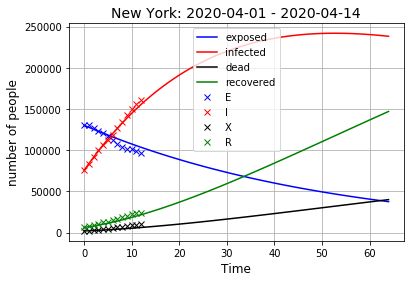

In [9]:
params = SEIR()

### Example1: California

Data complete, ready to analyze.
Suggest choosing start date after 2020-04-02


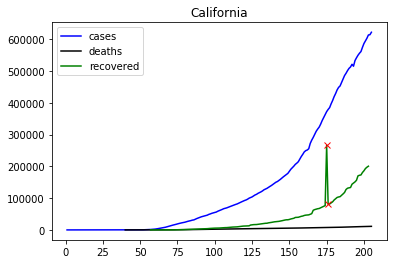

In [10]:
state = "California"
df_state = chooseState(state)
# df_state.sample(5).sort_values("date")

Everything seems fine (except that jump), then we choose an appropriate time period to analyze

Optimization for lamda_E, lamda_Q, alpha, omega, miu
params0:  [0.041081, 0.016432, 0.006, 0.000878, 0.008011]
params:  [0.0, 0.045369, 0.036708, 0.000896, 0.011187]


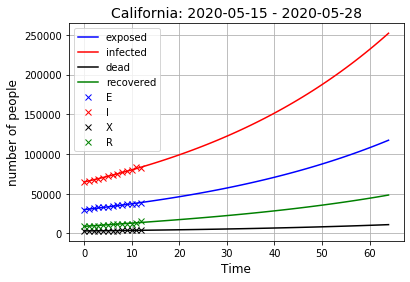

In [11]:
start_date, end_date = "2020-05-15", "2020-05-28"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR()

Optimization for lamda_E, lamda_Q, alpha, omega, miu
params0:  [0.04607, 0.018428, 0.006, 0.000639, 0.007465]
params:  [0.104967, 0.0, 0.029081, 0.000671, 0.012498]


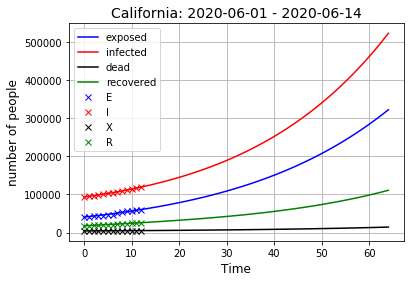

In [12]:
start_date, end_date = "2020-06-01", "2020-06-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR()

### Example2: New York

Data complete, ready to analyze.
Suggest choosing start date after 2020-03-27


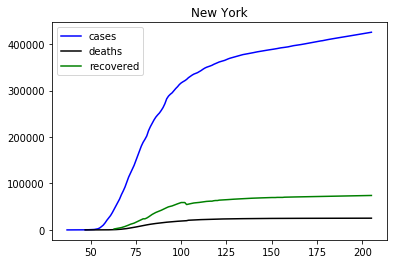

In [13]:
state = "New York"
df_state = chooseState(state)
# df_state.sample(5).sort_values("date")

Everything seems fine, then we choose an appropriate time period to analyze.

Optimization for lamda_E, lamda_Q, alpha, omega, miu
params0:  [0.013285, 0.005314, 0.006, 0.001107, 0.002479]
params:  [0.045351, 0.0, 0.0, 0.00049, 3e-05]


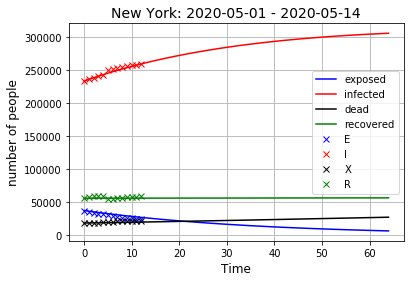

In [14]:
start_date, end_date = "2020-05-01", "2020-05-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR()

Optimization for lamda_E, lamda_Q, alpha, omega, miu
params0:  [0.005608, 0.002243, 0.006, 0.000159, 0.002127]
params:  [0.0, 0.00216, 0.0, 0.0, 0.000556]


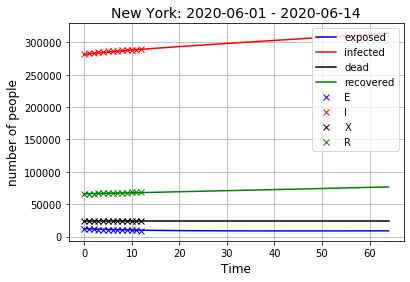

In [15]:
start_date, end_date = "2020-06-01", "2020-06-14"
sample, sample_future = chooseTime(df_state, start_date, end_date)
params = SEIR()

### Example3: Illinois

Data incomplete, cannot analyze.
NA cols:  ['recovered', 'hospitalized']
Suggest choosing start date after 2020-03-17


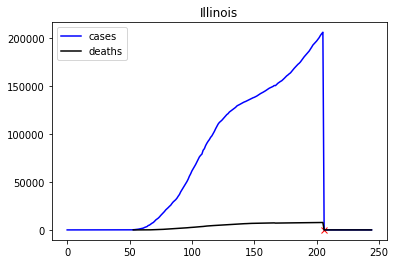

In [16]:
state = "Illinois"
df_state = chooseState(state)
# df_state.sample(5).sort_values("date")

There are too many missing data (no recovered data) for Illinois, we can not analyze now. 

### Example4: Texas

Data incomplete, cannot analyze.
NA cols:  ['hospitalized']
Suggest choosing start date after 2020-03-30


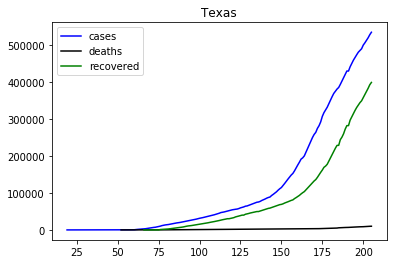

In [17]:
state = "Texas"
df_state = chooseState(state)
# df_state.sample(5).sort_values("date")

Data for hospitalized is missing, we may use the average k instead. We can not analyze now. 